In [11]:
from thesis_MLR import yhat_predict
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

model_folder = '/Users/darianng/Documents/MSc_Geography/MSc Thesis/Data/Model/'
model_coeff = pd.read_csv(model_folder+'Young2factor_coeff_full.csv')
model = pd.read_csv(model_folder+'Young2factor_fitted_full.csv')
del model['Unnamed: 0']
model_coeff = model_coeff.rename(columns={'Unnamed: 0': 'x_var'})
model1_name = 'Full Model'

model_coeff_stepwise = pd.read_csv(model_folder+'Young2factor_coeff_autocorr_bestAIC.csv')
model_stepwise = pd.read_csv(model_folder+'Young2factor_fitted_autocorr_bestAIC.csv')
del model_stepwise['Unnamed: 0']
model_coeff_stepwise = model_coeff_stepwise.rename(columns={'Unnamed: 0': 'x_var'})
model2_name = 'best AIC Model with temporal autocorrelation'


In [2]:
print(f'             -Full model- \nfixed terms: \n{[x_var for x_var in model_coeff["x_var"] if ":" not in x_var and "(" not in x_var]}')
print(f'interaction terms: \n{[x_var for x_var in model_coeff["x_var"] if "f6:" in x_var or "f2022:" in x_var]}')
print(f'\n             -Test model- \nfixed terms: \n{[x_var for x_var in model_coeff_stepwise["x_var"] if ":" not in x_var and "(" not in x_var]}')
print(f'interaction terms: \n{[x_var for x_var in model_coeff_stepwise["x_var"] if "f6:" in x_var or "f2022:" in x_var]}')

             -Full model- 
fixed terms: 
['month.f6', 'month.f7', 'month.f8', 'month.f9', 'year.f2022', 'NDVI', 'NDWI', 'NDMI', 'temp']
interaction terms: 
['month.f6:NDVI', 'month.f6:NDWI', 'month.f6:NDMI', 'month.f6:temp', 'year.f2022:NDVI', 'year.f2022:NDWI', 'year.f2022:NDMI', 'year.f2022:temp']

             -Test model- 
fixed terms: 
['month.f6', 'month.f7', 'month.f8', 'month.f9', 'year.f2022', 'NDVI', 'NDWI', 'NDMI', 'temp']
interaction terms: 
['month.f6:NDWI', 'month.f6:NDMI', 'year.f2022:temp']


In [3]:
# model_coeff_stepwise,model_coeff

# Predicting on Single Footprint-weighted Flux Map (non-clustered) 

In [4]:
# Finding L8 date to validate on:
site_name = 'Young'
MANUAL = 1
if 'removed_L8' in model_stepwise.columns:
    # Altering L8 to fit ffp format with extra leading 0 in date
    excluded_L8 = model_stepwise['removed_L8'][0]
    # Get associated ffp
    ffp_folder = '/Users/darianng/Documents/Msc_Geography/Methane_Hotspot/FARF_Code/python_code/Saved_Data_Cluster_May2023'
    for root, dirs, files in os.walk(ffp_folder):
        for dir_name in dirs:
            if site_name in dir_name and str(excluded_L8) in dir_name:
                excluded_ffp = dir_name.split('=')[1].split('_')[0]
    print(f'-Detected-\nExcluded ffp: {excluded_ffp}\nExcluded L8: {excluded_L8}')
# Manually choice
elif MANUAL ==1:
    excluded_ffp = '202106029-202107029'
    excluded_L8 = 20210714
    print(f'-Manually selected-\nExcluded ffp: {excluded_ffp}\nExcluded L8: {excluded_L8}')
else:
    print(f'No test run selected yet')

-Manually selected-
Excluded ffp: 202106029-202107029
Excluded L8: 20210714


In [5]:
from thesis import preprocess_maps

ffp_path = '/Users/darianng/Documents/MSc_Geography/Methane_Hotspot/FARF_Code/python_code/data/compilation/Young'
data = preprocess_maps(siteName = 'Young',fluxmap_filename = excluded_ffp,L8_date = excluded_L8,ffp_datapath = ffp_path)
# Creating the new DataFrame
columns_to_select = ['NDVI','NDWI','NDMI','temp']
observation = pd.DataFrame({col: data['landsat'][col] for col in columns_to_select})
month = [int(str(data['run'][0])[4:6])]*len(observation['NDVI'])
year = [int(str(data['run'][0])[:4])]*len(observation['NDVI'])
observation['month.f'] = month
observation['year.f'] = year
yhat_pred = yhat_predict(observation=observation,model_coeff=model_coeff_stepwise)
print(f'Check length of yhat: {len(yhat_pred)}')

Beginning resolution matching: /471
0%..10%..21%..31%..42%..53%..63%..74%..84%..95%..DONE
Check length of yhat: 471


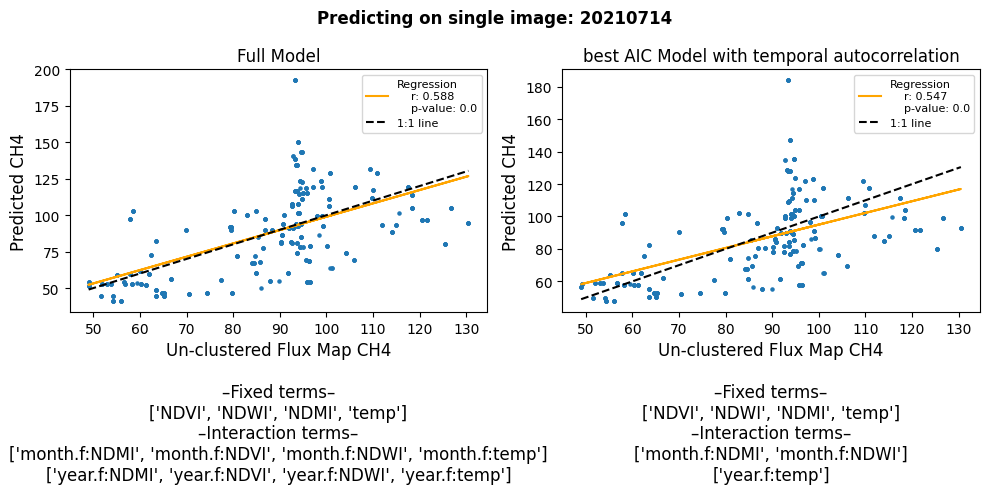

In [6]:
from scipy import stats
import matplotlib.pyplot as plt
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
yhat_pred = yhat_predict(observation=observation,model_coeff=model_coeff)
# Model details:
fixed_terms = [term for string in model_coeff['x_var'] for term in string.split() if ".f" not in term][1:]
interact1_fixed = np.unique([string.split(':')[1] for string in model_coeff['x_var'] if ":" in string and "month" in string])
interact2_fixed = np.unique([string.split(':')[1] for string in model_coeff['x_var'] if ":" in string and "year" in string])
interaction1_terms = ['month.f:'+term for term in interact1_fixed]
interaction2_terms = ['year.f:'+term for term in interact2_fixed]
x_data= data['matched_ffp']['ch4']
y_data = yhat_pred
# Regression data
plt.scatter(x_data,y_data,s=5)
m, b = np.polyfit(x_data,y_data,1)
yfit_line = m*np.array(x_data)+b
r_val, p_val = stats.pearsonr(x_data,y_data); corr = f'Regression\n    r: {np.round(r_val,3)} \n    p-value: {np.round(p_val,3)}'
plt.plot(x_data,yfit_line,'orange',label=corr)

plt.plot([min(x_data),max(x_data)],[min(x_data),max(x_data)],'--k',label='1:1 line')
plt.ylabel(f'Predicted CH4',fontsize=12); 
plt.xlabel(f'Un-clustered Flux Map CH4\n\n–Fixed terms–\n{fixed_terms}\n–Interaction terms–\n{interaction1_terms}\n{interaction2_terms}',fontsize=12)
plt.title(f'{model1_name}')
plt.legend(fontsize=8)

plt.subplot(1,2,2)
yhat_pred = yhat_predict(observation=observation,model_coeff=model_coeff_stepwise)
# Model details:
fixed_terms = [term for string in model_coeff_stepwise['x_var'] for term in string.split() if ".f" not in term][1:]
interact1_fixed = np.unique([string.split(':')[1] for string in model_coeff_stepwise['x_var'] if ":" in string and "month" in string])
interact2_fixed = np.unique([string.split(':')[1] for string in model_coeff_stepwise['x_var'] if ":" in string and "year" in string])
interaction1_terms = ['month.f:'+term for term in interact1_fixed]
interaction2_terms = ['year.f:'+term for term in interact2_fixed]
x_data= data['matched_ffp']['ch4']
y_data = yhat_pred
# Regression data
plt.scatter(x_data,y_data,s=5)
m, b = np.polyfit(x_data,y_data,1)
yfit_line = m*np.array(x_data)+b
r_val, p_val = stats.pearsonr(x_data,y_data); corr = f'Regression\n    r: {np.round(r_val,3)} \n    p-value: {np.round(p_val,3)}'
plt.plot(x_data,yfit_line,'orange',label=corr)

plt.plot([min(x_data),max(x_data)],[min(x_data),max(x_data)],'--k',label='1:1 line')
plt.ylabel(f'Predicted CH4',fontsize=12)
plt.xlabel(f'Un-clustered Flux Map CH4\n\n–Fixed terms–\n{fixed_terms}\n–Interaction terms–\n{interaction1_terms}\n{interaction2_terms}',fontsize=12)
plt.title(f'{model2_name}')
plt.suptitle(f'Predicting on single image: {data["run"][0]}',fontweight='bold')
plt.legend(fontsize=8)
plt.tight_layout()

# Predicting on Single Footprint-weighted Flux Map (clustered)

In [7]:
from thesis import preprocess_maps
from thesis import ffp_clustering

data, fig = ffp_clustering(data,GHG_var='ch4',n_clusters=5)
plt.close()
# Creating the new DataFrame
columns_to_select = ['NDVI','NDWI','NDMI','temp']
observation = pd.DataFrame({col: data['clustered_landsat'][col] for col in columns_to_select})
month = [int(str(data['run'][0])[4:6])]*len(observation['NDVI'])
year = [int(str(data['run'][0])[:4])]*len(observation['NDVI'])
observation['month.f'] = month
observation['year.f'] = year

Confirming current Gas: ch4


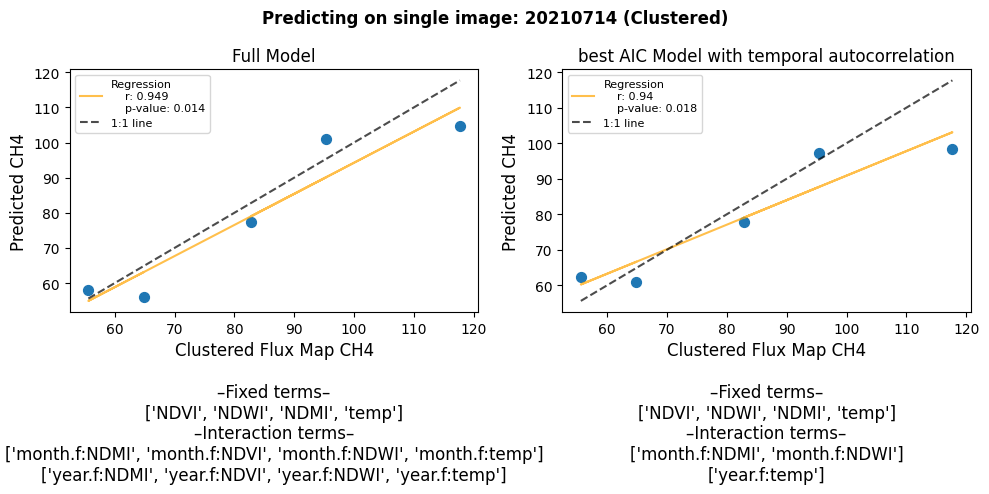

In [8]:
from scipy import stats
import matplotlib.pyplot as plt
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
yhat_pred = yhat_predict(observation=observation,model_coeff=model_coeff)
# Model details:
fixed_terms = [term for string in model_coeff['x_var'] for term in string.split() if ".f" not in term][1:]
interact1_fixed = np.unique([string.split(':')[1] for string in model_coeff['x_var'] if ":" in string and "month" in string])
interact2_fixed = np.unique([string.split(':')[1] for string in model_coeff['x_var'] if ":" in string and "year" in string])
interaction1_terms = ['month.f:'+term for term in interact1_fixed]
interaction2_terms = ['year.f:'+term for term in interact2_fixed]
x_data= data['clustered_ffp']
y_data = yhat_pred
# Regression data
plt.scatter(x_data,y_data,s=50)
m, b = np.polyfit(x_data,y_data,1)
yfit_line = m*np.array(x_data)+b
r_val, p_val = stats.pearsonr(x_data,y_data); corr = f'Regression\n    r: {np.round(r_val,3)} \n    p-value: {np.round(p_val,3)}'
plt.plot(x_data,yfit_line,'orange',label=corr,alpha=0.7)

plt.plot([min(x_data),max(x_data)],[min(x_data),max(x_data)],'--k',label='1:1 line',alpha=0.7)
plt.ylabel(f'Predicted CH4',fontsize=12); 
plt.xlabel(f'Clustered Flux Map CH4\n\n–Fixed terms–\n{fixed_terms}\n–Interaction terms–\n{interaction1_terms}\n{interaction2_terms}',fontsize=12)
plt.title(f'{model1_name}')
plt.legend(fontsize=8)

plt.subplot(1,2,2)
yhat_pred = yhat_predict(observation=observation,model_coeff=model_coeff_stepwise)
# Model details:
fixed_terms = [term for string in model_coeff_stepwise['x_var'] for term in string.split() if ".f" not in term][1:]
interact1_fixed = np.unique([string.split(':')[1] for string in model_coeff_stepwise['x_var'] if ":" in string and "month" in string])
interact2_fixed = np.unique([string.split(':')[1] for string in model_coeff_stepwise['x_var'] if ":" in string and "year" in string])
interaction1_terms = ['month.f:'+term for term in interact1_fixed]
interaction2_terms = ['year.f:'+term for term in interact2_fixed]
x_data= data['clustered_ffp']
y_data = yhat_pred
# Regression data
plt.scatter(x_data,y_data,s=50)
m, b = np.polyfit(x_data,y_data,1)
yfit_line = m*np.array(x_data)+b
r_val, p_val = stats.pearsonr(x_data,y_data); corr = f'Regression\n    r: {np.round(r_val,3)} \n    p-value: {np.round(p_val,3)}'
plt.plot(x_data,yfit_line,'orange',label=corr,alpha=0.7)

plt.plot([min(x_data),max(x_data)],[min(x_data),max(x_data)],'--k',label='1:1 line',alpha=0.7)
plt.ylabel(f'Predicted CH4',fontsize=12)
plt.xlabel(f'Clustered Flux Map CH4\n\n–Fixed terms–\n{fixed_terms}\n–Interaction terms–\n{interaction1_terms}\n{interaction2_terms}',fontsize=12)
plt.title(f'{model2_name}')
plt.suptitle(f'Predicting on single image: {data["run"][0]} (Clustered)',fontweight='bold')
plt.legend(fontsize=8)
plt.tight_layout()

# Predicting on another year's growing season

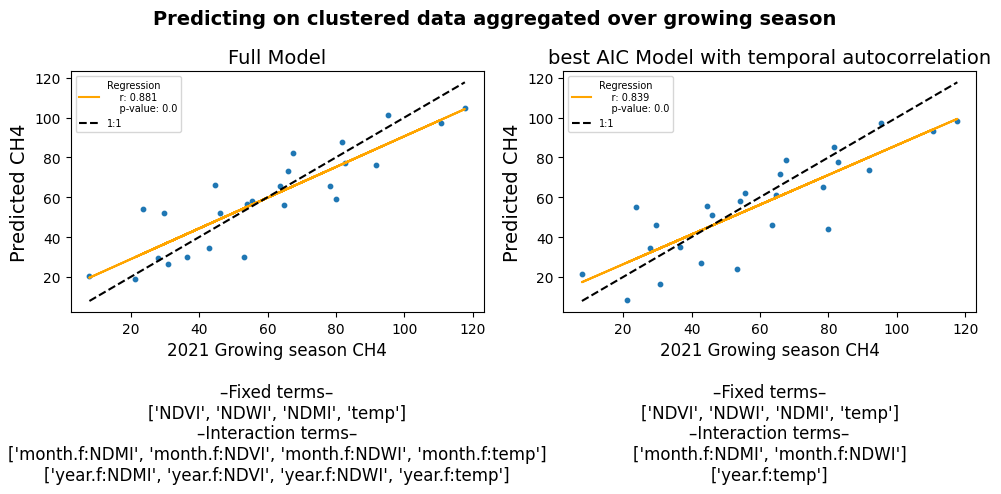

In [9]:
import pickle
with open('/Users/darianng/Documents/MSc_Geography/MSc Thesis/Data/Compilation/Young_Annual/2021_growing_season/compiled_data.p', 'rb') as fp:
    growing_2021 = pickle.load(fp)
# Making model-formatted dataframe
columns_to_select = ['NDVI','NDWI','NDMI','temp']
observation = pd.DataFrame({col: growing_2021['collapsed_landsat'][col] for col in columns_to_select})
observation['month.f'] = growing_2021['collapsed_landsat']['month']
observation['year.f'] = [int(str(run)[:4]) for run in growing_2021['collapsed_landsat']['period']]
observed_year = str(observation['year.f'][0])

plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
yhat_pred = yhat_predict(observation=observation,model_coeff=model_coeff)
fixed_terms = [term for string in model_coeff['x_var'] for term in string.split() if ".f" not in term][1:]
interact1_fixed = np.unique([string.split(':')[1] for string in model_coeff['x_var'] if ":" in string and "month" in string])
interact2_fixed = np.unique([string.split(':')[1] for string in model_coeff['x_var'] if ":" in string and "year" in string])
interaction1_terms = ['month.f:'+term for term in interact1_fixed]
interaction2_terms = ['year.f:'+term for term in interact2_fixed]

x_data= growing_2021['collapsed_ffp']
y_data = yhat_pred
# Regression data
plt.scatter(x_data,y_data,s=10)
m, b = np.polyfit(x_data,y_data,1)
yfit_line = m*np.array(x_data)+b
r_val, p_val = stats.pearsonr(x_data,y_data); corr = f'Regression\n    r: {np.round(r_val,3)} \n    p-value: {np.round(p_val,3)}'
plt.plot(x_data,yfit_line,'orange',label=corr)

plt.plot([min(x_data),max(x_data)],[min(x_data),max(x_data)],'--k',label='1:1')
plt.ylabel('Predicted CH4',fontsize=14)
plt.xlabel(f'{observed_year} Growing season CH4\n\n–Fixed terms–\n{fixed_terms}\n–Interaction terms–\n{interaction1_terms}\n{interaction2_terms}',fontsize=12)
plt.title(f'{model1_name}',fontsize=14)
plt.legend(fontsize=7)

plt.subplot(1,2,2)
yhat_pred = yhat_predict(observation=observation,model_coeff=model_coeff_stepwise)
fixed_terms = [term for string in model_coeff_stepwise['x_var'] for term in string.split() if ".f" not in term][1:]
interact1_fixed = np.unique([string.split(':')[1] for string in model_coeff_stepwise['x_var'] if ":" in string and "month" in string])
interact2_fixed = np.unique([string.split(':')[1] for string in model_coeff_stepwise['x_var'] if ":" in string and "year" in string])
interaction1_terms = ['month.f:'+term for term in interact1_fixed]
interaction2_terms = ['year.f:'+term for term in interact2_fixed]

x_data= growing_2021['collapsed_ffp']
y_data = yhat_pred
# Regression data
plt.scatter(x_data,y_data,s=10)
m, b = np.polyfit(x_data,y_data,1)
yfit_line = m*np.array(x_data)+b
r_val, p_val = stats.pearsonr(x_data,y_data); corr = f'Regression\n    r: {np.round(r_val,3)} \n    p-value: {np.round(p_val,3)}'
plt.plot(x_data,yfit_line,'orange',label=corr)

plt.plot([min(x_data),max(x_data)],[min(x_data),max(x_data)],'--k',label='1:1')
plt.ylabel('Predicted CH4',fontsize=14)
plt.xlabel(f'{observed_year} Growing season CH4\n\n–Fixed terms–\n{fixed_terms}\n–Interaction terms–\n{interaction1_terms}\n{interaction2_terms}',fontsize=12)
plt.title(f'{model2_name}',fontsize=14)
plt.suptitle(f'Predicting on clustered data aggregated over growing season',fontweight='bold',fontsize=14)
plt.legend(fontsize=7)
plt.tight_layout()

In [38]:
# Analyzing model parameters:
factors = [term for term in model_coeff_stepwise['x_var'] if ".f" in term and ":" not in term]
fixed_terms = [term for string in model_coeff_stepwise['x_var'] for term in string.split() if ".f" not in term][1:]
interact1_fixed = np.unique([string.split(':')[1] for string in model_coeff_stepwise['x_var'] if ":" in string and "month" in string])
interact2_fixed = np.unique([string.split(':')[1] for string in model_coeff_stepwise['x_var'] if ":" in string and "year" in string])
interaction1_terms = ['month.f:'+term for term in interact1_fixed]
interaction2_terms = ['year.f:'+term for term in interact2_fixed]

print('•Random Factors•')
for term in factors: print(f' -{term}')
print('\n•Fixed Effect•') 
for term in fixed_terms: print(f' -{term}')
print('\n•Interaction Terms•') 
for term in interaction1_terms: print(f' -{term}')
print(f'      --      ')
for term in interaction2_terms: print(f' -{term}')

•Random Factors•
 -month.f6
 -month.f7
 -month.f8
 -month.f9
 -year.f2022

•Fixed Effect•
 -NDVI
 -NDWI
 -NDMI
 -temp

•Interaction Terms•
 -month.f:NDMI
 -month.f:NDWI
      --      
 -year.f:temp


In [39]:
model_coeff

,x_var,x
0,(Intercept),34.548810
1,month.f6,1007.508491
2,month.f7,13.980770
3,month.f8,-102.084091
4,month.f9,-7.583759
5,year.f2022,-7.391751
6,NDVI,-227.926610
7,NDWI,-188.322520
8,NDMI,77.355171
9,temp,-1.219031
